<a href="https://colab.research.google.com/github/jinwu99/Text-mining-and-Sentiment-analysis/blob/main/Sentiment%20Analysis/Youtube_comment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('./MyDrive')

Mounted at ./MyDrive


In [ ]:
cd MyDrive/My Drive/Colab Notebooks

/content/MyDrive/My Drive/Colab Notebooks


#가설검증
병자호란이 대중에게 정말 부정적으로 인식되는가.
* 영화처럼 주관적 매체가 아닌, 역사강의처럼 객관적 매체를 통한 검증

In [ ]:
import pandas as pd

youtube = pd.read_csv('Youtube_review.csv').dropna(axis=0)
train_list = youtube['review'].tolist()
train_list[:5]

['첨부터 끝까지 잘봤습니다.<br>차분하게 소개해 주시고 역사자료를 통하여 인물들의 성향을 이해하기 쉽게 해석해 주셔서 참 좋았어요',
 '지도자 답지  않은 놈들은 바로바로 처단해야 된다.\n항상\n개돼지들만 피해',
 '우리 역사는 항상 병자호란처럼 사후약방문이 됩니다. 시청\n하는 내내 모멸감,굴욕감 때문에 수치스러워서 감당하기이를데  없었습니다. 탁상공론과\n정당화하려는 김상헌과 김류등 안봐도 액션스텐스 취하는데 혀가 내둘립니다. 평소 김상헌을 깊이 존경하였는데 이제부터 최명길의 실리외교를\n신봉하게 되었습니다.오월동주,와신상담사자성어가 떠오릅니다.영상 고맙게 잘 시청했습니다.',
 '현실적 vs  비현실적\n친미 vs 미군철수\n역사는  반복된다',
 '조선은 이때 망하고 새 왕조가 들어 섰어야한다']

#데이터분석 계획
1. 유튜브 역사강의 댓글 특징 :
    * 채널주인 평가, 역사 평가, 현재를 돌아보는 등 다양한 문맥을 가짐.
    * 따라서 클러스터링으로 문맥을 나누고 역사 관련 문맥만 추출.

2. 문맥에 따라 클러스터링하기 위해 - 문장을 비슷한 문맥끼리 가깝게 임베딩해주는 SBERT 활용.
3. 클러스터링 이후에 각 클러스터별로 Topic 추출하여 역사문맥 클러스터 구분
4. 세부적인 내용도 함께 파악하기 위해 GPT(ChatGPT)로 요약.

## SBERT embedding

In [ ]:
!pip install sentence_transformers

In [ ]:
import numpy as np
from sentence_transformers import SentenceTransformer
import torch

model = SentenceTransformer("jhgan/ko-sroberta-multitask")
model.to('cuda') # 빠른 임베딩 시키자.

with torch.no_grad():
    document_embeddings = model.encode(train_list, convert_to_tensor=True)
document_embeddings = document_embeddings.to('cpu').numpy()
print(document_embeddings.shape)

np.save('sentence_embeddings_only_youtube', document_embeddings)

In [ ]:
document_embeddings = np.load('sentence_embeddings_only_youtube.npy')

## Clustering
* Cosine Similarity기반으로 임베딩된 댓글들의 유사도 측정
* 아웃라이어에 강건하면서 비유클리디안 기반 거리에 활용 가능한 K-medoids clustering활용
* Silhouette 점수 기반으로 최적의 클러스터수 결정

In [ ]:
!pip install scikit-learn-extra

Text(0, 0.5, 'Silhoutte Score')

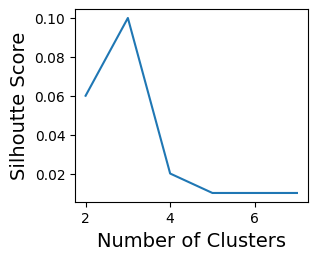

In [ ]:
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

silh = []
for k in range(2,8):
    kmedoids = KMedoids(n_clusters=k, random_state=0, metric='cosine')
    cluster_labels = kmedoids.fit_predict(document_embeddings)
    silhoutte = silhouette_score(document_embeddings, cluster_labels, metric='cosine')
    silh.append(silhoutte)

plt.figure(figsize=(3,2.5))
plt.plot([2,3,4,5,6,7],np.round(silh,2))
plt.xlabel('Number of Clusters',fontdict={'size': 14})
plt.ylabel('Silhoutte Score',fontdict={'size': 14})

In [ ]:
best_k = 3
kmedoids = KMedoids(n_clusters=best_k, metric='cosine', random_state=0)
cluster_labels = kmedoids.fit_predict(document_embeddings)
youtube['kmedoids'] = cluster_labels

youtube.to_csv('Youtube_review.csv',
               index=False,
               encoding='utf-8-sig')

## Topic 추출
* 각 클러스터는 이미 문맥에 따라 묶였으므로 - 주제가 하나씩만 있다고 가정.
* Latent Dirichlet Allocation(LDA)로 Topic 추출.
* WordCloud 활용하여 시각화.

In [ ]:
!pip install konlpy # 한국어를 처리하는 대표적인 형태소 분석 패키지

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 36.4 MB/s eta 0:00:00


In [ ]:
from konlpy.tag import *
okt = Okt()

tokenized_doc = [okt.pos(corp, norm=True, stem=True) for corp in train_list]
tokenized_doc = [[word[0] for word in doc if word[1] in ['Noun','Verb','Adjective']] for doc in tokenized_doc]
tokenized_doc = [[n for n in corp if len(n) > 1] for corp in tokenized_doc]

# 불용어 처리
stopwords = ['하다','이다','보다','있다','되다','먹다','같다','많다','되어다','않다','해주다','없다']
tokenized_doc = [[word for word in corp if not word in stopwords] for corp in tokenized_doc]

np.save('tokenized_morphs_youtube', np.array(tokenized_doc))

<ipython-input-14-dfd41407f592>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save('tokenized_morphs_youtube', np.array(tokenized_doc))


In [ ]:
from gensim import corpora
from gensim.models import LdaModel

tokenized_doc = np.load('tokenized_morphs_youtube.npy', allow_pickle=True)

# 각 클러스터별 토큰화된 단어들 나눠주기
doc_clusts = [np.array(tokenized_doc)[youtube['kmedoids']==k,].tolist()
              for k in range(best_k)]

# 각 클러스터별 정수인코딩 객체
dic_clusts = [corpora.Dictionary(doc_clust)
              for doc_clust in doc_clusts]

# 각 클러스터별 각 토큰들을 정수인코딩
corp_clusts = [[dic_clusts[k].doc2bow(text) for text in doc_clusts[k]]
               for k in range(3)]

best_ks = [1,1,1]

# 각 클러스터별로 LDA 돌리기
lda_models = [LdaModel(corp_clusts[k], num_topics=best_ks[k], id2word=dic_clusts[k], passes=15)
              for k in range(3)]

In [ ]:
# Pythohn Plot에 한글 표시하기 위해 한글폰트를 다운받아야함
!apt-get update -qq
!apt-get install fonts-nanum* -qq

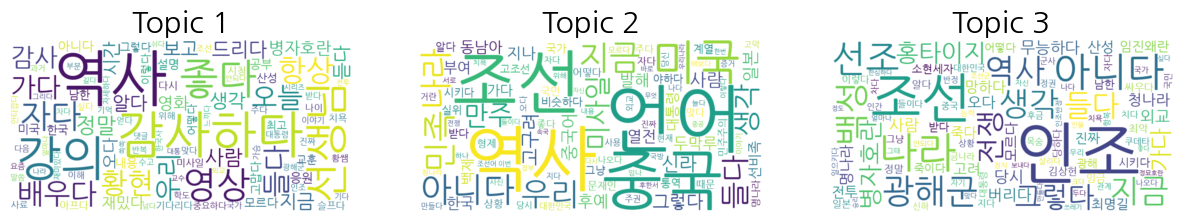

In [ ]:
import matplotlib.font_manager as fm
from wordcloud import WordCloud

fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# Plot the word cloud
fig, axs = plt.subplots(1,3,figsize=(15,4))
for topic_id in range(best_k):
    # Get the top words for the topic
    topic_words = lda_models[topic_id].show_topic(topicid=0,topn=100)
    wordcloud_dict = {word: prob for word, prob in topic_words}

    # Create the word cloud
    wordcloud = WordCloud(font_path=path, width=800, height=400,
                        background_color='white').generate_from_frequencies(wordcloud_dict)

    axs[topic_id].imshow(wordcloud,interpolation='bilinear')
    axs[topic_id].set_title(f"Topic {topic_id+1}")
    axs[topic_id].axis('off')

Topic 1 : 채널주인에 대한 평가 \
Topic 2 : 역사를 통해 현재 정세를 돌아봄 \
Topic 3 : 역사 평가 \
따라서 Topic 2와 Topic 3를 집중적으로 세부내용 조사

##ChatGPT활용한 세부내용 파악
* 각 클러스터별로 텍스트를 복사하여 ChatGPT로 내용 요약요청.
* 그러나 인풋으로 넣을 수 있는 토큰 길이가 4096로 제한됨.
    * Option 1 : 각 클러스터의 글을 인풋 가능한 길이의 여러개로 나누어 GPT입력
        * 그러나 Python으로 API사용시 돈이 필요함.
    * Option 2 : BART로 글을 요약하여 토큰 길이를 줄이고 GPT입력
        * 돈이 필요하지 않으나 SBART 또한 인풋 길이 제한으로,  인풋 가능한 길이의 여러개로 나누어 SBART입력.
        * SBART요약만으로는 가독성이 좋지 않아서 GPT로 다시 refine해달라 요청.

###각 역사 인물에 대한 평가
* 클러스터3에서 남한산성 대표 인물인 '인조', '최명길', '김상헌'을 언급한 댓글들만 추출하여 세부내용 파악

In [ ]:
import re
import numpy as np

youtube_review = youtube['review'].tolist()
youtube_clusts = [np.array(youtube_review)[youtube['kmedoids']==k,].tolist()
                for k in range(3)]

# 한글 빼고 다 지우기.
youtube_clusts = [[re.sub(r"[^ㄱ-ㅣ가-힣\s]", "", doc) for doc in youtube_clust] for youtube_clust in youtube_clusts]
# 개행도 다 지우기.
youtube_clusts = [[''.join(doc.splitlines()) for doc in youtube_clust] for youtube_clust in youtube_clusts]

In [ ]:
# 먼저 김상헌에 대한 댓글들 추출 및 댓글들 길이 확인
Kim_Sang_youtube_lst = [doc for doc in youtube_clusts[2] if '김상헌' in doc]
Kim_Sang_youtube = ' '.join(Kim_Sang_youtube_lst)
print(len(Kim_Sang_youtube))
Kim_Sang_youtube

2004


'인조는 그렇다 치고김상헌 이놈은 우파 인데  왜 전쟁터 안나가는거냐  ㅎㅎㅎ 인조나 김상헌 같은 조선대신들이 외교에서 얼마나 무능하고 어리석었는지 안타깝네요 죽을라고   맘만 먹고 아무도 안보는데서 분만 목매달면  얼마든지 죽을 수 있을텐데  절개있는 선비인 척  굳이 가족들이 보는 앞에서 목을  매달려고 했던 위선자 김상헌그 당시  상황을 연출하면  이랬다는 거 아닙니까   김상헌이  가족들이 보는 앞에서  목매달면서  왈  에잇  이 애비는  원통해서 자결하련다  라고 목매달려고 하니  자식들 왈  아버님  이러시면 아니되옵니다 라고  육갑지랄들 떨었다는 거 아닙니까    기가 막혀서  웃음만 나옵니다 전쟁이 나면 군량미는 어떻게 조달할지   군사들은 어떻게 훈련시키고  모집할 지   병장기는 어떻게 조달할 지  구체적인  실행계획  실천계획은 없이오직 주둥아리만 살아 있던 조선시대  사대부 무지랭이들 그 중심에  위선자 김상헌같은 안동김씨등  세상이 어떻게 돌아가는지  무식했던 사대부들이 있었습니다 명쾌한   해설 감사합니다  호란 가장 큰 책임은 인조   그리고 김상헌을 비롯한 현실을 외면한 자들유생들은 최명길에  침을 밷고송시열은 최명길은 소인배   김상헌은 대로라고  흥선대원군이나 대로라는  극존칭을 받았지요    김상헌의 직계후손이 순조 헌종 철종비가 되지요  안동 김씨의 세도정치  매관매직이 쓰러져가는  조선의 운명을 앞당긴거지요 김상헌은 스스로 자결하지도 못했고 그 후손들이 노론이 되어 나라를 절단냈으니 참으로 더러운 놈이다 김상헌은 일본의 스파이였다 이건진짜 온 국민이 봐야할듯 영화보다 더 실감나네요인조를보니 저시대 왕도 참 힘들었겠다 싶네요 지금의 잣대가아닌 저시대의 잣대였다면 김상헌도 나름 이해가 되긴하네요 그렇지만 최명길이 저 시대에 있었다란건 조선과 지금의 대한민국에는 행운 인조가 현명 했다고 봐야지 척화파 김상헌이 그런놈 말듣고 최명길이 참수했으면 조선 국호는 없어졌지 탤런트 최명길도 없었을테고 ㅎ 그렇다고 목숨도 내놓지 못한 김상

In [ ]:
# ChatGPT에 충분히 입력할 수 있는 분량.
# 아래는 ChatGPT요약한 내용 :
Kim_Sang_youtube_chatgpt = ['김상헌에 대한 댓글들은 주로 부정적인 내용으로, 그의 무능함과 어리석음을 비판하며 전쟁 상황에서의 무능함, 외교적 무지, 위선적 행동 등을 지적하고 있습니다. 김상헌의 후손들에 대해서도 나쁜 평가를 내리며, 조선의 신하로서의 책임과 백성들에 대한 무관심을 비판하는 목소리가 많습니다. 그의 역사적 역할에 대한 의문과 비판, 그리고 김상헌을 통해 조선시대의 사회적 현실을 비판하는 댓글들도 있습니다. 대체로 그의 역사적 기여와 신하로서의 역할을 부정적으로 평가하는 댓글들이 주를 이루고 있습니다.']

In [ ]:
# 최명길에 대한 댓글들 추출 및 댓글들 길이 확인
Choi_Myeong_youtube_lst = [doc for doc in youtube_clusts[2] if '최명길' in doc]
Choi_Myeong_youtube = ' '.join(Choi_Myeong_youtube_lst)
print(len(Choi_Myeong_youtube))
Choi_Myeong_youtube

2357


'최명길은  훌륭한 신하였습니다 사학도님 병자호란 의 진실을 알려면 최명길 을 키우고 가르친 장만장군 부터 알려주세요 장만장군 은 최명길 의 장인으로서 광해 의 중립외교와 전략을 직접 만든 인물입니다 장만장군   검색해 주세요 명쾌한   해설 감사합니다  호란 가장 큰 책임은 인조   그리고 김상헌을 비롯한 현실을 외면한 자들유생들은 최명길에  침을 밷고송시열은 최명길은 소인배   김상헌은 대로라고  흥선대원군이나 대로라는  극존칭을 받았지요    김상헌의 직계후손이 순조 헌종 철종비가 되지요  안동 김씨의 세도정치  매관매직이 쓰러져가는  조선의 운명을 앞당긴거지요 최명길은 사직 을 하고 온 조정이 탄핵하고  쫓겨남 최명길 ㅡㅡ  살펴야합니다   하루아침에 적의 기마병이몰려오고  파천을 하게되는 날이 오면  어떻 압록 강이  얼면  청나라기마부대가 그위로 달려오면  어떡  최명길의 이러한 말이  안먹히고 나라가 망하더라도  의리를 지키자고  라 라 ㅡㅡ하였던 조정  개월 뒤에   전쟁이 실재로 나고 지금이야 결과를 아니깐 최명길이 맞는것 같지 저당시에 명이 이길지 청이 이길지 알수가 없는 상황인게 그당시 현실인거고 왜란때 명나라의 도움을 받은 사실을 외면한다면 그것 또한 비열한 선택이라는 오명을 얻게 되는것 지금에 와서 뭐가 옳고 그른지 따지는것은 아무 의미가 없다 그때 그랬어야 했었다 라고 할수있는건 결과를 알기 때문일뿐이다멍청하다 무능하다라고 비난할 필요도 없다 최명길 진짜 존나 답답했겠다 어후 이건진짜 온 국민이 봐야할듯 영화보다 더 실감나네요인조를보니 저시대 왕도 참 힘들었겠다 싶네요 지금의 잣대가아닌 저시대의 잣대였다면 김상헌도 나름 이해가 되긴하네요 그렇지만 최명길이 저 시대에 있었다란건 조선과 지금의 대한민국에는 행운 광해군이 최명길이 됨 ㅋㅋ 조선은 최명길 이 살린게 맞다  광해때 잘하지  인조가 현명 했다고 봐야지 척화파 김상헌이 그런놈 말듣고 최명길이 참수했으면 조선 국호는 없어졌지 탤런트 최명길도 없었을테고 ㅎ 조선이 믿는 것은 오로지 하

In [ ]:
# ChatGPT에 충분히 입력할 수 있는 분량.
# 아래는 ChatGPT요약한 내용 :
Choi_Myeong_youtube_chatgpt = ['최명길에 대한 댓글들은 전반적으로 긍정적인 분위기를 띠고 있으며, 그의 충성심을 인정하고 지혜를 칭찬하는 내용이 많습니다. 병자호란과 같은 중요한 역사 사건에서의 역할을 인정하며, 조선의 미래를 더 나은 방향으로 이끌 수 있는 그의 통찰력을 존경하는 목소리가 있습니다. 몇몇 댓글들은 그 시대의 복잡성을 고려하여, 최명길과 같은 지도자들이 직면한 어려움과 역사적 결과의 불확실성을 언급하고 있습니다. 전반적으로 그의 지혜와 조선 역사에 대한 기여에 대한 감사함이 느껴집니다.']

In [ ]:
# 인조에 대한 댓글들 추출 및 댓글들 길이 확인
In_Jo_youtube_lst = [doc for doc in youtube_clusts[2] if '인조' in doc]
In_Jo_youtube = ' '.join(In_Jo_youtube_lst)
print(len(In_Jo_youtube))
In_Jo_youtube

23717


'인조는 진짜 암군 중의 암군  아들들을 잘 둔 건 인정 호부견자가 아니고 견부호자 인조는 무뇌인이었다그래서 백성믄 내팽개치고 혼자만 괜찮으면 된다는 사고방식을 가지고 있는 군왕이 어찌 군왕이 맞겠는가 인조는 그렇다 치고김상헌 이놈은 우파 인데  왜 전쟁터 안나가는거냐  ㅎㅎㅎ 역사는 돌고돈다 저당시를 지금에비하면 명나라는 미국이고 인조는 가카이시네ㅎㅎㅎㅎ 인조나 김상헌 같은 조선대신들이 외교에서 얼마나 무능하고 어리석었는지 안타깝네요  세상에 이런 쪼다가 어디있단 말인가 자기 자신은 무서우니 자식을 내보내려하다니 인조는 저때 붙잡혀가고 소현세자가 왕이 됐어야했다 무능하고 우유부단한 인조는 반정으로 광해군을 몰아내고 집권하는 과감성은 어디서 나왔을꼬실로 통탄할 일이로다 인조에 대해서 조금이나마동정이  가네요지금까지는 인조를 역대 왕들중제일무능하고 구차한목숨을살았다고 생각 했는데하여튼 보는내내 가슴이갑갑 하였습니다 명쾌한   해설 감사합니다  호란 가장 큰 책임은 인조   그리고 김상헌을 비롯한 현실을 외면한 자들유생들은 최명길에  침을 밷고송시열은 최명길은 소인배   김상헌은 대로라고  흥선대원군이나 대로라는  극존칭을 받았지요    김상헌의 직계후손이 순조 헌종 철종비가 되지요  안동 김씨의 세도정치  매관매직이 쓰러져가는  조선의 운명을 앞당긴거지요 인조패거리들은 건방지고 오만하고 무식한 수구꼴통 국짐당 스럽다 애초에 인조라는 임금이 꽝이지명나라 모시다가 당하기나하고광해군이 참 안됬찌 인조반정 을 한 뒤라서  백성들의 민심이  왕에게  올 일은 없을듯  광해군 은 좀 알지만 ㅡㅡㅡ인 조는 민심은 바랄수 없는 상황 인데다가  그야말 로  최악의 상황이네요 인조 의말이 구구절절이  바른 말이고 입장을 분명히 했네요  ㅎㅎㅎ 외교공부 다시해라 아군끼리 싸우는 멍청한  청치꾼들 인조반정으로 인조반정으로 정권 잡았지만  조선역사상 가장 무능하고 사악하고 비겁한 군주였다 그 밑의 부하들 그 나물에 그 밥 조선역사 민중들 후퇴시킨 가장 무능한 군주 쪼다 조선 최악의 임

In [ ]:
# ChatGPT가 인풋가능한 글 길이를 넘기므로 SBART활용하여 요약
!pip install transformers

from transformers import PreTrainedTokenizerFast, BartForConditionalGeneration

tokenizer = PreTrainedTokenizerFast.from_pretrained('gogamza/kobart-summarization')
model = BartForConditionalGeneration.from_pretrained('gogamza/kobart-summarization')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.8 MB/s eta 0:00:00


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BartTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [ ]:
# BART의 인풋 길이 제한은 1024토큰
# 인조 댓글들의 각 댓글의 평균 길이는?
np.mean([len(doc) for doc in In_Jo_youtube_lst])

96.20491803278688

In [ ]:
# 그러면 대략 1024토큰 안에 몇개의 댓글을 넣을 수 있을까?
1024 // np.mean([len(doc) for doc in In_Jo_youtube_lst])

10.0

In [ ]:
# 인조에 대한 총 댓글 갯수 :
len(In_Jo_youtube_lst)

244

In [ ]:
# 댓글 10개당 요약 아웃풋 길이
4098//(len(In_Jo_youtube_lst)//10+1)

163

In [ ]:
# 나중에 Chatgpt에 명령어 넣을 것도 포함해서 - 넉넉잡아 70으로 max_length 잡자.

In [ ]:
import torch

intv = 10
summary_texts = ''
for k in range(round(244/intv)+1):
    print('from ',0+k*intv,' to ',(k+1)*intv)
    input_ids = tokenizer.encode(' '.join(In_Jo_youtube_lst[(0+k*10):((k+1)*10)]))
    input_ids = [tokenizer.bos_token_id] + input_ids + [tokenizer.eos_token_id]
    input_ids = torch.tensor([input_ids])
    # 혹시라도 SBART에 못넣는 인풋이 있을 경우, 생략.
    try:
        summary_ids = model.generate(input_ids,  num_beams=4,  max_length=70,  eos_token_id=1)
    except:
        print('exception occured at ', 0+k*intv,' to ',(k+1)*intv)
        continue
    summary_texts += tokenizer.decode(summary_ids.squeeze().tolist(), skip_special_tokens=True) + ' '

print(len(summary_texts))
summary_texts

from  0  to  10
from  10  to  20
from  20  to  30
from  30  to  40
from  40  to  50
from  50  to  60
from  60  to  70
from  70  to  80
from  80  to  90
from  90  to  100
from  100  to  110
from  110  to  120
from  120  to  130
from  130  to  140
from  140  to  150
from  150  to  160
from  160  to  170
from  170  to  180
from  180  to  190
from  190  to  200
from  200  to  210
from  210  to  220
from  220  to  230
from  230  to  240
from  240  to  250
2902


'인조는 무능하고 우유부단한 인조는 반정으로 광해군을 몰아내고 집권하는 과감성은 어디서 나왔을꼬실로 통탄할 일이로다  명쾌한   해설 감사합니다  호란 가장 큰 책임은 인조   그리고 김상헌을 비롯한 현실을 외면한 자들유생들은 최명길에 인조반정으로 정권 잡았지만  조선역사상 가장 무능하고 사악하고 비겁한 군주였다 그 밑의 부하들 그 나물에 그 밥 조선역사 민중들 후퇴시킨 가장 무능한 군주 쪼다 조선 최악의 임금 선조의 피를 그대로 이어 받은 찌질한 인조 후금 기병의 위 아조반정으로 왕 되었지만 무능하고 외교적 사리도 못갖춘 정말 무능한 욍 청나라 홍타이지 정말 명석하고 관대하고 사려깊은 지도자다 내가 그 였다면 반드시 척화파 간신들을 모조리 참살하고 인조의 목을베어 광화문에 걸고 조선의 광해군을 폐위시킨  인조반정 은 당초부터 잘못된 것이였다  인조가 즉위한지 년만에 정묘호란년 나라가 쑥대밭이 되었고 병자호란 년만에 또한번 나라를 곤경에 빠뜨린 병자호란년 을 당하게 된 인조는 선조와 더불어 우리 광해군을 몰아내고 나라와 백성에게 크나큰 시련을 안겨준 조선 최대의 폭군인 인조는 개인의 복수심으로 광해군을 몰아내고 나라와 백성에게 크나큰 시련을 안겨준 조선 최대의 폭군이었다고 봅니다 윤석렬의 미일올인 사대정책을 보면 꼭 그때의 인조를 보는것 같습니다  사대주의에빠진 언론과 국짐 친일파 놈들이  그때 광해를 공격했던 사림놈들과 똑같고 어리버리 왕권을 줏었던 윤석렬이 얼마나 똑같은지ᄏᄏ 개국공신중 하나였던 왕다운 인격 능력도 없는 찌질이가 왕이랍시고 백성을 힘들게 하며 권위만 내세우고 나라를 망가뜨렸던 인조 선조 그리고 미친폭군 연산군 개 쓰레기 인조 개새광해군 몰아내더니 그때 싹 쓸어버렸어야 했는데 인조는  임금자격없고  군으로 강등 인조에 으뜸또라이 선조ᄋ 인조가 얼마나 ᄇᄉ같고 위협이 안된다고 생각했으면 목숨을 살려줬을까 조선은 망국의 원흉이었다 조서니 임금중 가장 우왕인 인조 그 휘하 사대부들 개드립에 수십만 백성들이 북방으로 노예로 끌려갔었는데도 인조와 개드

In [ ]:
# 위의 BART요약을 Chatgpt으로 refine한 이후 :
In_Jo_youtube_chatgpt = ['인조에 대한 댓글들은 크게 두 가지 주제로 나뉘어집니다. 첫 번째 주제는 인조의 통치 무능과 관련한 내용입니다. 그는 무능한 군주로 평가되며, 광해군을 몰아내고 집권한 반정의 결정은 큰 실수였다고 비판되고 있습니다. 이에 따라 국가와 백성에 큰 시련을 안겼다는 의견도 나타납니다. 이러한 평가로 인해 인조의 결정력 부족과 통치 능력에 대한 의문이 촉발되었습니다. 두 번째 주제는 광해군과의 비교와 관련한 내용입니다. 광해군과 인조의 정치적 비교가 다양하게 나타나며, 광해군의 선택이 후금과의 화친을 택한 반면, 인조의 결정은 국가 위기를 초래했다는 평가도 있습니다. 또한 광해군과 인조의 정치 비교를 통해 현대의 리더십과 중요성에 대한 의견도 언급되고 있습니다. 이외에도 윤석열과 문재인에 대한 비판, 종교적 극단주의, 조선 역사의 다양한 측면에 관한 논의가 포함되어 있습니다. 이들 주제들이 조선의 역사와 인조의 통치에 대한 다양한 시각과 의견을 반영하고 있습니다.']

In [ ]:
np.save('Choi_Myeong_youtube_chatgpt', np.array(Choi_Myeong_youtube_chatgpt))
np.save('Kim_Sang_youtube_chatgpt', np.array(Kim_Sang_youtube_chatgpt))
np.save('In_Jo_youtube_chatgpt', np.array(In_Jo_youtube_chatgpt))